<a href="https://colab.research.google.com/github/Dogegowow/catsdogs/blob/main/catsdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pozdravljeni, v tej beležki Google Colab bom naredil algoritem za razvrščanje mačk in psov s knjižnjico Tensorflow. Nevronsko mrežo bom naučil na setu podatkov iz Kaggle: https://www.kaggle.com/datasets/tongpython/cat-and-dog. Mrežo bom naučil v Google Colabu, kasneje bom kodo vključno s podatki naložil še na Github za lažjo uporabo.

In [57]:
import cv2
import os
import numpy as np
from os import path
import keras
from keras import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, ReLU
from keras import Model
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Tu vstavite še svojo pot na računalniku do slik.
Naj ne bo pred in za njo nič presledkov. -- path

Za testiranje podajte celotno pot s končnico slike vred. -- image_path

In [68]:
path = "/content/drive/MyDrive/catdog/test_set"
image_path = "/content/drive/MyDrive/catdog/test_set/cats/cat.4990.jpg"

V tem sklopu kode se določi numpy array z črno-belo vrednostjo slike ter ID-jem za psa ali mačko.

In [34]:
data = []
for folder in os.listdir(path):
  if os.path.isdir(f"{path}/{folder}"):
    for files in os.listdir(f"{path}/{folder}"):
      zival = files.split('.')[0]
      if zival == 'cat':
        image = cv2.resize(cv2.imread(f"{path}/cats/{files}"), (100, 100))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data.append([gray, np.array([0, 1])])
      elif zival == 'dog':
        image = cv2.resize(cv2.imread(f"{path}/dogs/{files}"), (100, 100))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data.append([gray, np.array([1, 0])])

Tu se definira predhodne efekte, ki bodo delovali na sliki, preden bo kot neka številka posredovana nevronski mreži za razvrščanje.

Conv2D pomeni konvolucija, pri čemer se vzame kernel z matrico 3x3, ki se sprehaja po sliki in s tem ustvari nekakšno mrežo številk, ki se uporabljajo za nadajnje postopke. To se naredi za vsakega od treh (RGB) kanalov.

MaxPooling2D vzame največjo vrednost iz kernela in odpusti ostale ter s tem downsiza sliko.

Flatten to tridimenzionalno sliko, ki je sestavljena iz višine, širine in rgb kanalov splošči v eno dimenzijo.

To se poda nevroski mreži, ki jo definiramo z Dense, v mojem primeru imam dva layerja, enega z 512 nodi in enega z dvemi.

In [2]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 32)        1

Tu naš array z vrednostmi razdelimo na train in test split v razmerju 9:1.
Vrednostim, ki predstavljajo slike, spremenimo v previlne dimenzije, v našem primeru imamo 4.
Nato z prej določenimi parametri modela compilamo model in je pripravljen za trening.

In [36]:
train , test = train_test_split(data, test_size = 0.1, shuffle = True)
X = np.array([i[0] for i in train]).reshape(-1, 100, 100, 1)
Y = np.array([i[1] for i in train])

x_valid = np.array([i[0] for i in test]).reshape(-1, 100, 100, 1)
y_valid = np.array([i[1] for i in test])
X = X.astype('float32')/255
x_valid = x_valid.astype('float32')/255
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss= 'categorical_crossentropy', optimizer= opt, metrics=['accuracy'])

Zdaj bom natreniral nevronsko mrežo. S številom epochov lahko spreminjamo čas, potreben za treniranje, vendar to obratno sorazmerno deluje na natančnost modela.

In [37]:
model.fit(X, Y, batch_size= 10, epochs= 30, verbose= 1, validation_data=(x_valid,y_valid))

Epoch 1/3
12/12 [==============================] - 13s 965ms/step - loss: 0.6877 - accuracy: 0.6814 - val_loss: 0.6632 - val_accuracy: 0.8462
Epoch 2/3
12/12 [==============================] - 9s 754ms/step - loss: 0.6705 - accuracy: 0.6814 - val_loss: 0.6145 - val_accuracy: 0.8462
Epoch 3/3
12/12 [==============================] - 8s 659ms/step - loss: 0.6452 - accuracy: 0.6814 - val_loss: 0.5278 - val_accuracy: 0.8462


Z zagonom teh zadnjih dveh odsekov pa lahko preverite natančnost svojega izdelanega modela.

In [40]:
classes = {0:"Cat",1:'Dog'}
for i in classes.items():
    print(i)

(0, 'Cat')
(1, 'Dog')


1/1 [==============================] - 0s 48ms/step
Cat


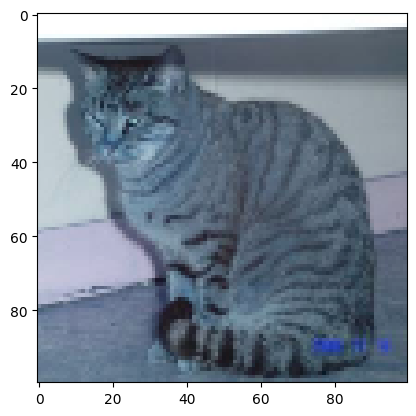

In [69]:
new_img = cv2.resize(cv2.imread(image_path), (100, 100))
gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
gray = gray.reshape(1, 100, 100, 1)
prediction = model.predict(gray)
prediction = np.argmax(prediction,axis=1)
print(classes[prediction[0]])
plt.imshow(new_img)